# **Approche non supervisée**

In [1]:
# Pour manipuler nos données
import pandas as pd

# Gensim - Pour les prédictions de tags
import gensim
import gensim.corpora as corpora
from gensim.models import CoherenceModel
from gensim.models import Nmf
from gensim.models import TfidfModel

# Visualisations
import matplotlib.pyplot as plt
import pyLDAvis
import pyLDAvis.gensim
from wordcloud import WordCloud

# Mesures de performance des prédictions
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, hamming_loss
from sklearn.preprocessing import MultiLabelBinarizer  # Utilisé dans la fonction de qualité des prédictions

# Mesures de durée d'éxécution
import time

# Utilisé lors des sauvagardes et chargement de données/objets
import pickle
import os

# Éviter les Deprecation Warning avec NMF
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

Ce notebook fonctionne avec : 

- Python 3.10.9
- Anaconda 23.3.1
- Wordcloud 1.9.2
- Gensim 4.3.0
- pyLDAvis 3.4.1

- Mesure de la durée d'exécution du notebook : 

In [2]:
t_notebook = time.time()

## **Importations des données**

In [3]:
with open('data_clean.pkl', 'rb') as fichier:
    data = pickle.load(fichier)

data

,date,corpus,corpus_dl,tags
0,2022-05-08 21:22:05,"[firebase, testing, jest, error, assertion, cl...","[firebase, testing, with, jest, throws, error,...","[firebase, jestjs, reactjs]"
1,2022-05-08 21:49:08,"[block, hack, language, benefit, block, job, w...","[concurrent, block, in, hacklang, since, hack,...","[async-await, concurrency]"
2,2022-05-08 21:49:57,"[type, function, typescript, function, type, i...","[can, you, set, a, type, for, a, function, in,...",[typescript]
3,2022-05-08 21:51:00,"[store, service, account, looking, expo, appli...","[expo, eas, submit, where, to, store, service,...",[expo]
4,2022-05-08 22:32:53,"[store, retrieve, structure, type, c, copying,...","[reliably, and, portably, store, and, retrieve...",[c]
...,...,...,...,...
46493,2022-03-21 08:52:43,"[option, option, know, option, case, option, o...","[how, to, know, if, a, select2, has, options, ...","[javascript, jquery]"
46494,2022-03-21 08:54:03,"[ring, plot, attempt, gap, use, plot, paint, r...","[matplotlib, how, to, plot, a, closed, ring, i...","[matplotlib, python]"
46495,2022-03-21 09:02:54,"[security, problem, terraform, dependency, loc...","[which, security, problem, does, terraform, ch...",[terraform]
46496,2022-03-21 13:54:21,"[studio, creation, blob, container, error, mes...","[visual, studio, 2022, with, azurite, integrat...",[azure]


## **Option d'échantillonages pour la réalisation de tests**

In [4]:
echantillon = False
taille_echantillon = 5000

if echantillon:
    data = data.sample(taille_echantillon, random_state=42)  # random_state car en fonction de l'échantillonage
                                                             # les résultats peuvent changer et pour pouvoir
                                                             # comparer nos tunings d'hyperparamètres, nous devons
                                                             # avoir des résultats reproductibles

data

,date,corpus,corpus_dl,tags
0,2022-05-08 21:22:05,"[firebase, testing, jest, error, assertion, cl...","[firebase, testing, with, jest, throws, error,...","[firebase, jestjs, reactjs]"
1,2022-05-08 21:49:08,"[block, hack, language, benefit, block, job, w...","[concurrent, block, in, hacklang, since, hack,...","[async-await, concurrency]"
2,2022-05-08 21:49:57,"[type, function, typescript, function, type, i...","[can, you, set, a, type, for, a, function, in,...",[typescript]
3,2022-05-08 21:51:00,"[store, service, account, looking, expo, appli...","[expo, eas, submit, where, to, store, service,...",[expo]
4,2022-05-08 22:32:53,"[store, retrieve, structure, type, c, copying,...","[reliably, and, portably, store, and, retrieve...",[c]
...,...,...,...,...
46493,2022-03-21 08:52:43,"[option, option, know, option, case, option, o...","[how, to, know, if, a, select2, has, options, ...","[javascript, jquery]"
46494,2022-03-21 08:54:03,"[ring, plot, attempt, gap, use, plot, paint, r...","[matplotlib, how, to, plot, a, closed, ring, i...","[matplotlib, python]"
46495,2022-03-21 09:02:54,"[security, problem, terraform, dependency, loc...","[which, security, problem, does, terraform, ch...",[terraform]
46496,2022-03-21 13:54:21,"[studio, creation, blob, container, error, mes...","[visual, studio, 2022, with, azurite, integrat...",[azure]


## **Vectorisation du corpus**

In [5]:
# Création d'un dictionnaire avec le vocabulaire de notre corpus
id2word = corpora.Dictionary(data['corpus'])

# Vocabulaire présent dans le corpus
print(f"Taille du dictionnaire (donc du vocabulaire de notre corpus) : {len(id2word)}")

# Création d'un corpus encodé en bag of word (bow) classique
corpus = []
for text in data['corpus']:
    new = id2word.doc2bow(text)
    corpus.append(new)


# Création d'un corpus encodé en bag of word (bow) TF-IDF
tfid_model = TfidfModel(corpus)  # On reprend le bow classique et en entraîne TfidfModel()
tfid_corpus = tfid_model[corpus]  # Création du corpus encodé en bow TF-IDF


print("-"*50)

# Pour exemple, les 20 premiers mots (encodé en bow) du premier document de notre corpus
print(f"Premier document encodé (BoW classique): {corpus[0][0:20]}")
print(f"Premier document encodé (BoW TF-IDF): {tfid_corpus[0][0:20]}")

Taille du dictionnaire (donc du vocabulaire de notre corpus) : 3707
--------------------------------------------------
Premier document encodé (BoW classique): [(0, 2), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 2), (8, 1), (9, 5), (10, 1), (11, 1), (12, 1), (13, 1), (14, 1), (15, 1), (16, 2), (17, 2), (18, 1)]
Premier document encodé (BoW TF-IDF): [(0, 0.1668978989187718), (1, 0.19508508258305074), (2, 0.1524602824824453), (3, 0.07973756058173015), (4, 0.10041788894510228), (5, 0.12184385748614651), (6, 0.13360136877961093), (7, 0.09134209452828705), (8, 0.05765666737692792), (9, 0.7575962604963911), (10, 0.16468633046490613), (11, 0.13071420832152275), (12, 0.09053013243017625), (13, 0.2206450870370584), (14, 0.09539226016825238), (15, 0.22856128820091243), (16, 0.1861261518919339), (17, 0.2754749019906323), (18, 0.05593617396136383)]


## **Premier modèle : LDA (Latent Dirichlet Allocation)**

### **A). Avec corpus en BoW classique**

- Tests pour déterminer le nombre de sujets qui apporte le meilleur score de cohérence (CV) : 

<div class="alert alert-info">
Le score de cohérence 'c_v' est un nombre réel qui mesure à quel point les mots à l'intérieur de chaque topic sont similaires les uns aux autres en termes de co-occurrence dans les documents. Un score de cohérence plus élevé indique des topics plus cohérents, c'est-à-dire que les mots à l'intérieur d'un topic ont tendance à apparaître ensemble dans les documents. Il permet d'évaluer la qualité d'un modèle de topic modeling (ici LDA). Plus le score de cohérence est élevé, meilleure est la cohérence des topics.
</div>

In [6]:
# Les tests étant très longs, ne les lançons pas à chaque exécution du notebook
do_test = False

if do_test:

    tests_results_lda = {}

    for i in range(0, 201, 5):  # Il n'est pas pertinent de tester au delà de 200 topics
                                # puisque nous avons précédemment restreint le nombre de tags uniques à 200

        num_topics_lda = i

        # Il faut au moins un sujet
        if i == 0:
            num_topics_lda = i + 1

        lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                                id2word=id2word,
                                                num_topics=num_topics_lda,
                                                random_state=100,
                                                update_every=1,
                                                chunksize=100,
                                                passes=10,
                                                alpha="auto")
        
        coherence_model = CoherenceModel(model=lda_model, texts=data['corpus'], dictionary=id2word, coherence='c_v')

        coherence_score = coherence_model.get_coherence()

        tests_results_lda[lda_model.num_topics] = coherence_score

        print(f"{lda_model.num_topics} topics : {coherence_score:.4f}")

    nom_fichier = 'num_topics_lda'
    # Export du dataset data
    if os.path.isfile(f'{nom_fichier}.pkl') == False:
        with open(f'{nom_fichier}.pkl', 'wb') as fichier:
            pickle.dump(tests_results_lda, fichier)
        print(f"Fichier {nom_fichier}.pkl créé.")
    else:
        print(f"Le fichier {nom_fichier}.pkl existe déjà, si vous souhaitez en exporter une nouvelle version, supprimez l'ancien.")

- Résultats : 

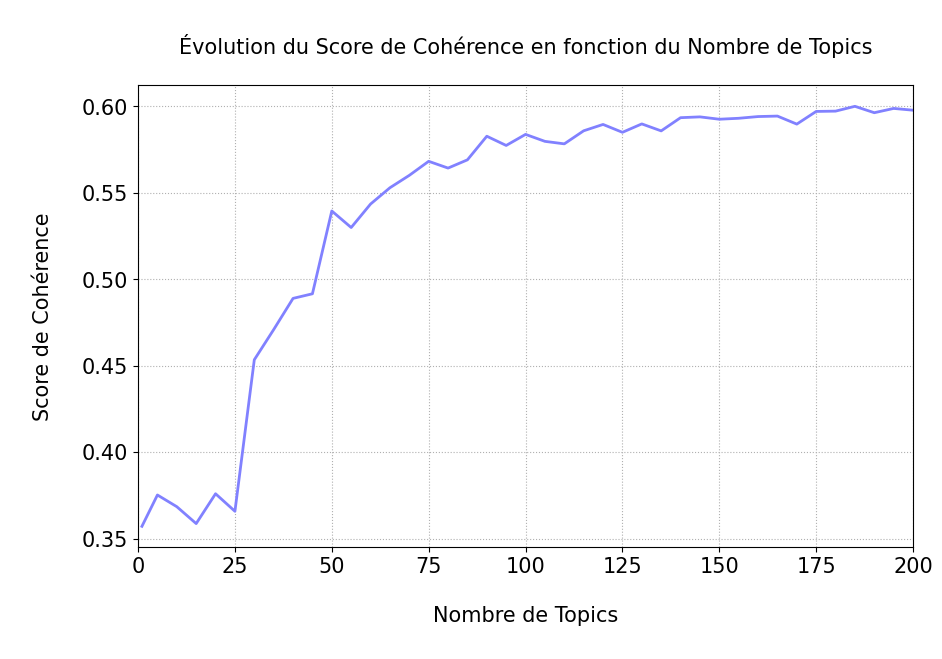

In [7]:
# Chargement des données provenant des tests réalisés (sur échantillon de 5000): 
with open('num_topics_lda.pkl', 'rb') as fichier:
    tests_results = pickle.load(fichier)

# Réprésentation graphique des résultats : 

num_topics = list(tests_results.keys())
coherence_scores = list(tests_results.values())

# Créer un graphique à l'aide de matplotlib
plt.figure(figsize=(10, 6))  # Définir la taille du graphique (facultatif)

# Tracer la courbe des scores de cohérence
plt.plot(num_topics, coherence_scores, linestyle='-', linewidth=2, color="#8181FF")

# Ajouter des étiquettes et un titre
plt.xlabel('\nNombre de Topics\n', fontsize=15)
plt.xticks(fontsize=15)
plt.xlim(0, 200)
plt.ylabel('\nScore de Cohérence\n', fontsize=15)
plt.yticks(fontsize=15)
plt.title('\nÉvolution du Score de Cohérence en fonction du Nombre de Topics\n', fontsize=15)

# Afficher le graphique
plt.grid(True, linestyle=":")
plt.show()

<div class="alert alert-info">
Le score de cohérence CV n'est qu'un indicateur parmi d'autres. Il ne doit pas être le seul critèque de choix. Le contexte métier est important ici : nous avons 200 tags uniques, le nombre de sujets à déterminer doit donc être assez important. Choisir par exemple de ne dégager que 10 sujets de tout notre corpus, alors que l'on tente de prédire 200 tags, ne serait pas pertinent.<br><br>
Nous devons également considérer le nombre de topics qui produiront les meilleurs résultats dans nos deux approches de proposition de tags qui vont suivre.<br><br>
Nous devons enfin garder en tête que l'augmentation du nombre de topics peut augmenter significativement les durées d'entraînement des modèles.
</div>

- Entraînement du modèle LDA avec un nombre de topics optimal (contexte métier, résultats pour nos deux approches et scores de cohérence à titre indicatif et de comparaison) : 

In [8]:
# Ce nombre de topics permet d'apporter les meilleurs résultats à nos approches
num_topics_lda = 150

debut = time.time()  # Heure de début du traitement

lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                            id2word=id2word,
                                            num_topics=num_topics_lda,
                                            random_state=100,
                                            update_every=1,
                                            chunksize=2000,
                                            passes=5,
                                            alpha="auto",
                                            eta='auto',
                                            iterations=10,
                                            decay=0.6,
                                            offset=1,
                                            gamma_threshold=0.001,
                                            minimum_probability=0.01
)

print(f"Durée du traitement : {(time.time() - debut):.2f} s")

Durée du traitement : 64.53 s


- Calcul du score de cohérence de ce modèle : 

In [9]:
debut = time.time()  # Heure de début du traitement

coherence_model = CoherenceModel(model=lda_model, texts=data['corpus'], dictionary=id2word, coherence='c_v')

coherence_score = coherence_model.get_coherence()

print(f"Durée du traitement : {(time.time() - debut):.2f} s")

print(f"Score de cohérence avec {lda_model.num_topics} topics : {coherence_score:.4f}")

Durée du traitement : 34.27 s
Score de cohérence avec 150 topics : 0.3825


- Affichage des topics trouvés avec ce modèle : 

*num_words* pour choisir le nombre de mot à afficher pour chaque topic<br>
À chaque mot est associé un nombre : son importance pour le topic en question.


In [10]:
# Nombre de mots à afficher pour chaque topics
num_words = 10

topics_lda = lda_model.show_topics(num_topics=lda_model.num_topics, num_words=num_words)

for topic in topics_lda[:10]: # 10 premiers seulement
    print(topic)

(0, '0.242*"color" + 0.193*"background" + 0.089*"role" + 0.064*"game" + 0.062*"policy" + 0.049*"invoke" + 0.041*"channel" + 0.035*"play" + 0.022*"dns" + 0.021*"bean"')
(1, '0.387*"purpose" + 0.129*"center" + 0.050*"consume" + 0.045*"sharing" + 0.043*"multiple" + 0.043*"forum" + 0.041*"compression" + 0.039*"jest" + 0.038*"terminate" + 0.035*"executor"')
(2, '0.137*"development" + 0.135*"push" + 0.124*"blazor" + 0.117*"bucket" + 0.071*"razor" + 0.058*"validate" + 0.039*"retry" + 0.033*"typing" + 0.031*"apis" + 0.030*"modify"')
(3, '0.288*"server" + 0.269*"variable" + 0.216*"point" + 0.082*"entry" + 0.038*"pair" + 0.017*"way" + 0.009*"example" + 0.008*"thing" + 0.007*"idea" + 0.006*"end"')
(4, '0.750*"column" + 0.044*"std" + 0.028*"complexity" + 0.017*"way" + 0.015*"example" + 0.014*"take" + 0.012*"mistake" + 0.012*"basis" + 0.011*"thank" + 0.008*"worksheet"')
(5, '0.210*"response" + 0.169*"spring" + 0.100*"start" + 0.100*"endpoint" + 0.082*"json" + 0.081*"boot" + 0.034*"oracle" + 0.032*"

### **Définitions de nos fonctions**

**Fonction pour calculer la qualité de nos tags prédits, donne les métriques suivantes :**

- **Accuracy score** : proportion d'échantillons pour lesquels toutes les étiquettes sont prédites correctement.
- **Precision score** : proportion des étiquettes prédites correctement par rapport à toutes les étiquettes prédites.
- **Recall score** : proportion de vrais positifs parmi toutes les étiquettes réelles.
- **F1 score** : moyenne pondérée de la précision et du rappel.
- **Hamming loss** : fraction des étiquettes qui ne sont pas correctement prédites par rapport au nombre total d'étiquettes, plus c'est faible, meilleur c'est.
- Documents avec **au moins un tag réel trouvé**.
- Documents avec **tous les tags réels trouvés** (même si d'autres tags sont prédits en plus).
- **Taux de couverture moyen** : moyenne de la proportion de tags réels trouvés pour chaque document.

In [11]:
def predict_quality(predict, real, txt=True):

    """
    Cette fonction permet d'évaluer la qualité de nos prédictions de tags
    -------------------
    predict : les tags prédits (sous forme de liste de liste, ou array de liste)
    real : les tags réels (sous forme de liste de liste, ou array de liste)
    txt (défaut : True) : si les tags ne sont pas vectorisés, ils le seront avec MultiLabelBinarizer

    """

    print("---------- Métriques classiques ----------")
          
    ##########################################
    # Métriques de classification classiques #
    ##########################################

    # Si les données sont sous forme de texte, il faut les vectoriser
    # pour calculer les métriques, je le fais avec MultiLabelBinarizer
    if txt:
        # Si la prédiction est non supervisée, cela crée des tags qui n'existent pas
        # dans les tags réels, ce qui va provoquer un warning
        # de MultiLabelBinarizer, disant qu'il va ignorer ces tags.
        # je désactive temporairement ce UserWarning
        warnings.filterwarnings("ignore", category=UserWarning)

        mlb = MultiLabelBinarizer()
        real_bin = mlb.fit_transform(real)
        predict_bin = mlb.transform(predict)

        warnings.filterwarnings("default", category=UserWarning)
    else:
        real_bin = real
        predict_bin = predict

    print(f"Accuracy score : {accuracy_score(real_bin, predict_bin):.3f}")

    # zero_division=0 : si une classe n'est pas du tout prédite correctement, la précision pour cette classe sera fixée à 0
    # average='weighted' : agrégation pondérée, car les classes ne sont pas équilibrées (certaines sont beaucoup plus fréquentes que d'autres)
    print(f"Precision score : {precision_score(real_bin, predict_bin, average='weighted', zero_division=0):.3f}")
    print(f"Recall score : {recall_score(real_bin, predict_bin, average='weighted'):.3f}")
    print(f"F1 score : {f1_score(real_bin, predict_bin, average='weighted'):.3f}")

    print(f"Hamming loss : {hamming_loss(real_bin, predict_bin):.3f}")

    print("---------- Métriques métier ----------")

    #################################################################################
    # Cas avec au moins un mot en commun entre les tags réels et les tags prédits : #
    #################################################################################

    # Variable qui sera incrémentée à chaque fois
    # qu'il y aura un mot en commun entre prédiction et réel
    common_word_count = 0

    for predict_tag, real_tag in zip(predict, real):

        # Je convertis en set pour pouvoir facilement comparer ensuite
        predict_tag = set(predict_tag)
        real_tag = set(real_tag)
        
        # 'predict & real' retourne un set contenant les valeurs communes
        # entre les deux s'il y en a. Sinon un set vide sera retourné
        if predict_tag & real_tag:
            common_word_count += 1

    # Calculer le pourcentage de cas où il y a au moins un mot en commun
    total_cases = len(real)  # Autrement dit, le nombre de documents
                             # en considérant qu'il y a des tags réels
                             # pour tous les documents
    percentage_common_word_cases = (common_word_count / total_cases) * 100

    print(f"Documents avec au moins un tag réel trouvé : {percentage_common_word_cases:.2f} %")

    ###################################################################
    # Cas où tous les tags réels apparaissent dans les tags prédits : #
    ###################################################################

    # Variable qui sera incrémentée à chaque fois que tous
    # les tags réels se trouveront dans les tags prédits
    all_found_count = 0

    for predict_tag, real_tag in zip(predict, real):

        # Je convertis en set pour pouvoir facilement comparer ensuite
        predict_tag = set(predict_tag)
        real_tag = set(real_tag)

        # real_tag <= predict_tag retourne True si tout le contenu
        # de real_tag est présent dans predict_tag
        if real_tag <= predict_tag:
            all_found_count += 1

    # On reprend total_cases calculé précédemment
    percentage_all_found_count = (all_found_count / total_cases) * 100

    print(f"Documents avec tous les tags réels trouvés : {percentage_all_found_count:.2f} %")

    ######################################
    # Calcul du taux de couverture moyen #
    ######################################

    # Les taux de couverture locaux seront stockés dans cette liste,
    # dans les cas supérieurs à 0 (au moins un tag trouvé)
    all_taux_couv = []

    for predict_tag, real_tag in zip(predict, real):

        # Je convertis en set pour pouvoir facilement comparer ensuite
        predict_tag = set(predict_tag)
        real_tag = set(real_tag)

        couv = real_tag & predict_tag  # Retourne les mots en commun entre les deux,
                                       # retourne un set vide si rien en commun
    
        if couv:  # Donc set non vide, au moins un mot en commun
            # Le nombre de mots en commun / le nombre total de tags réels
            all_taux_couv.append(len(couv)/len(real_tag))
        
    # On reprend total_cases calculé précédemment.
    # On divise bien par le total et non par all_taux_couv
    # car all_taux_couv ne contient que les valeurs
    # des cas où au moins un tag réel est trouvé
    taux_couv_moyen = (sum(all_taux_couv) / total_cases) * 100

    print(f"Taux de couverture moyen : {taux_couv_moyen:.2f} %")

    ######################################
    # Proportion d'absence de prédiction #
    ######################################

    # Nombre de documents qui n'ont pas de tags prédits
    docs_sans_tags_pred = sum(1 for sous_liste in predict if not sous_liste)

    # Pourcentage concerné
    absence_predict = docs_sans_tags_pred / len(predict) * 100

    # Je précise le nombre de documents concernés s'il y en a
    # qui n'ont pas de tags
    if docs_sans_tags_pred:
        docs_concernes = f" ({docs_sans_tags_pred} documents)"
    else:
        docs_concernes = ""

    print(f"Documents sans prédiction de tags : {absence_predict:.2f} %{docs_concernes}")



**Approche 1 :** Pour chaque document, on conserve les premiers mots (les plus probables) du topic le plus probablement associé au document : 

In [12]:
def approche1(model, premiers_mots, real_tags, show_ex=True, return_tags=False):

    """
    Cette fonction permet de réaliser notre première approche : 
    Pour chaque document, on conserve les premiers mots (les plus probables)
    du topic le plus probablement associé au document.

    Puis on utilise la fonction predict_quality()
    pour évaluer la qualité des prédictions.

    --------------------------

    - model : modèle (LDA, NMF) à utiliser.
    - premiers_mots : combien de premiers mots du topic on souhaite conserver.
    - real_tags : les tags réels pour évaluer la qualité des prédictions.
    - show_ex : montrer les tags prédits pour les 10 premiers documents.
    - return_tags : retourner les tags prédits.

    """

    # Liste pour stocker les mots les plus probables pour chaque document
    top_words_per_document = []

    debut = time.time()  # Heure de début du traitement

    # Parcourir les documents du corpus
    for doc in corpus:
        
        # Obtenir les probabilités d'appartenance aux topics pour ce document
        doc_topics = model.get_document_topics(doc)
        
        # Trouver le sujet le plus probable pour ce document
        most_probable_topic = max(doc_topics, key=lambda x: x[1])[0]
        
        # Obtenir les premiers mots les plus probables du sujet le plus probable
        top_words = model.show_topic(most_probable_topic, topn=premiers_mots)
        
        # Liste temporaire pour stocker les mots pour le document en cours
        temp_list = []
        for i in range(premiers_mots):
            temp_list.append(top_words[i][0])

        top_words_per_document.append(temp_list)

    # 'top_words_per_document' contient maintenant les x (= 'premiers_mots')
    #  premiers mots les plus probables pour le sujet le plus probable de chaque document.

    print(f"Durée du traitement : {(time.time() - debut):.2f} s\n")

    # Évaluation
    predict_quality(top_words_per_document, real_tags)

    if show_ex:
        # Exemples
        print("\nPour les 10 premiers documents : ")
        display(top_words_per_document[:10])

    if return_tags:
        return top_words_per_document

**Approche 2** : Pour chaque document, on conserve un nombre défini de mots (au maximum, si possible) qui sont à la fois présents dans le document d'origine et dans le topic le plus probablement associé au document.

In [13]:
def approche2(model, taille_topic, max_mots_communs, real_tags, show_ex=True, return_tags=False):

    """
    Cette fonction permet de réaliser notre deuxième approche : 
    Pour chaque document, on conserve un nombre défini de mots (au maximum, si possible)
    qui sont à la fois présents dans le document d'origine
    et dans le topic le plus probablement associé au document.

    Puisque cette approche peut générer des listes vides (aucun mot en commun),
    le pourcentage de listes vides est calculé.

    Puis on utilise la fonction predict_quality()
    pour évaluer la qualité des prédictions.

    --------------------------

    - model : modèle (LDA, NMF) à utiliser.
    - taille_topic : nombre de mots les plus probables du topic
                     associé au document, parmi lesquels on va
                     chercher des mots communs ceux du texte du document.
    - max_mots_communs : combien de mots commun on cherche au maximum.
    - real_tags : les tags réels pour évaluer la qualité des prédictions.
    - show_ex : montrer les tags prédits pour les 10 premiers documents.
    - return_tags : retourner les tags prédits.

    """

    # Liste pour stocker les x (x = taille_topic) mots du sujet les plus probables
    # et qui sont également présents dans le texte du document
    top_words_in_document = []

    debut = time.time()  # Heure de début du traitement

    # Parcourir les documents du corpus
    for i, doc in enumerate(corpus):

        # Obtenir les probabilités d'appartenance aux topics pour ce document
        doc_topics = model.get_document_topics(doc)
        
        # Trouver le sujet le plus probable pour ce document
        most_probable_topic = max(doc_topics, key=lambda x: x[1])[0]
                        
        # Obtenir les mots du sujet le plus probable
        # topn : les x (x = taille_topic) premiers mots du sujet (les plus probables)
        top_words = [word for word, _ in model.show_topic(most_probable_topic, topn=taille_topic)]
        
        # Conserver, parmi les x (x = taille_topic) premiers mots du sujet, ceux qui sont également présents dans le document
        words_in_document = [word for word in top_words if word in data['corpus'].iloc[i]]
            
        # Sélectionner jusqu'à 'max_mots_communs' mots du sujet présents dans le document
        selected_words = words_in_document[:max_mots_communs]
        
        top_words_in_document.append(selected_words)

    # 'top_words_in_document' contient maintenant, pour chaque document,
    # jusqu'à 'max_mots_communs' mots communs entre les 'taille_topic' premiers mots
    # du topic le plus probable pour le document et les mots présents dans le texte du document.

    print(f"Durée du traitement : {(time.time() - debut):.2f} s\n")

    # Puisque nous ne retenons que les cas avec des valeurs communes,
    # il est possible que dans certains cas nous n'ayons qu'une liste vide.
    # Calculons si cela arrive souvent : 
    empty_lists_count = sum(1 for words in top_words_in_document if not words)
    total_lists = len(top_words_in_document)
    percentage_empty_lists = (empty_lists_count / total_lists) * 100
    print(f"Pourcentage de listes vides : {percentage_empty_lists:.2f}%\n")

    # Évaluation
    predict_quality(top_words_in_document, real_tags)

    if show_ex:
        # Exemples
        print("\nPour les 10 premiers documents : ")
        display(top_words_in_document[:10])
    
    if return_tags:
        return top_words_in_document

### **Approche 1, avec les 5 premiers mots des topics**

In [14]:
approche1(lda_model,
          premiers_mots=5,
          real_tags=data['tags']
)

Durée du traitement : 106.96 s

---------- Métriques classiques ----------
Accuracy score : 0.023
Precision score : 0.151
Recall score : 0.048
F1 score : 0.056
Hamming loss : 0.011
---------- Métriques métier ----------
Documents avec au moins un tag réel trouvé : 8.83 %
Documents avec tous les tags réels trouvés : 2.75 %
Taux de couverture moyen : 5.28 %
Documents sans prédiction de tags : 0.00 %

Pour les 10 premiers documents : 


[['test', 'testing', 'other', 'case', 'report'],
 ['message', 'block', 'topic', 'code', 'chain'],
 ['type', 'typescript', 'way', 'example', 'hint'],
 ['account', 'get', 'trouble', 'pool', 'manage'],
 ['component', 'copy', 'domain', 'render', 'design'],
 ['script', 'pod', 'run', 'nextjs', 'guidance'],
 ['component', 'copy', 'domain', 'render', 'design'],
 ['interface', 'struct', 'provider', 'signature', 'auto'],
 ['button', 'count', 'minute', 'chart', 'code'],
 ['dataset', 'annotation', 'picture', 'world', 'training']]

### **Approche 2, avec 5 mots en commun avec le document (au maximum)**

In [15]:
approche2(lda_model,
          taille_topic=50,
          max_mots_communs=5,
          real_tags=data['tags']
)

Durée du traitement : 126.72 s

Pourcentage de listes vides : 0.00%

---------- Métriques classiques ----------
Accuracy score : 0.022
Precision score : 0.456
Recall score : 0.045
F1 score : 0.065
Hamming loss : 0.010
---------- Métriques métier ----------
Documents avec au moins un tag réel trouvé : 8.22 %
Documents avec tous les tags réels trouvés : 2.28 %
Taux de couverture moyen : 4.77 %
Documents sans prédiction de tags : 0.00 % (1 documents)

Pour les 10 premiers documents : 


[['test', 'testing', 'assertion', 'idea', 'use'],
 ['block'],
 ['type', 'typescript', 'way', 'case', 'thing'],
 ['account', 'expo', 'looking', 'way'],
 ['copy', 'use', 'alignment', 'copying', 'reason'],
 ['nextjs', 'need', 'lot'],
 ['component', 'code', 'problem', 'help'],
 ['coroutine', 'way'],
 ['button', 'need', 'call'],
 ['training', 'problem', 'thank']]

### **Visualisation des résultats de la LDA avec pyLDAvis**

In [16]:
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word, mds="mmds", R=30, n_jobs=1)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster      Freq
topic                                               
47    -0.092785 -0.049129       1        1  2.734533
129    0.090775 -0.250030       2        1  2.276064
90     0.055490  0.006696       3        1  2.237867
81    -0.228225 -0.173669       4        1  1.898053
140    0.069327 -0.334559       5        1  1.686789
...         ...       ...     ...      ...       ...
78    -0.376514  0.224864     146        1  0.205665
1     -0.162330  0.531843     147        1  0.189042
38     0.495589  0.156778     148        1  0.168091
141    0.526042  0.016178     149        1  0.129053
144   -0.556112 -0.035970     150        1  0.107264

[150 rows x 5 columns], topic_info=         Term          Freq         Total  Category  logprob  loglift
7       error  22475.000000  22475.000000   Default  30.0000  30.0000
8        file  20042.000000  20042.000000   Default  29.0000  29.0000
147     value  18038.000000  18038.000000   Default  28.0000  28.0000
27   function  17809.000000  17809.000000   Default  27.0000  27.0000
35       type  13355.000000  13355.000000   Default  26.0000  26.0000
..        ...           ...           ...       ...      ...      ...
89       code      0.009508  24501.841719  Topic150 -11.8364  -7.9245
257     image      0.008948   6113.414490  Topic150 -11.8971  -6.5970
679      look      0.008935   1023.246170  Topic150 -11.8985  -4.8109
79       time      0.008699   9793.344604  Topic150 -11.9252  -7.0963
59    example      0.008562  11500.848840  Topic150 -11.9412  -7.2730

[5694 rows x 6 columns], token_table=      Topic      Freq     Term
term                          
1056    150  0.928586      aad
961      55  0.997295  ability
1762    132  0.957285  absence
1632     52  0.985669   accept
166     107  0.999836   access
...     ...       ...      ...
2581     93  0.951126     yyyy
1253     34  0.996003     zero
2025    105  0.998194      zip
1309     51  0.994141     zone
683      57  0.984537     zoom

[5617 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[48, 130, 91, 82, 141, 63, 127, 17, 19, 109, 102, 31, 86, 29, 147, 71, 49, 4, 32, 124, 135, 117, 35, 5, 22, 107, 14, 41, 42, 66, 68, 104, 67, 146, 6, 133, 98, 61, 15, 112, 121, 20, 62, 110, 99, 27, 45, 80, 9, 75, 54, 53, 56, 36, 51, 33, 97, 115, 58, 129, 44, 23, 70, 1, 143, 18, 100, 40, 94, 60, 108, 46, 122, 128, 7, 134, 65, 30, 73, 87, 111, 11, 92, 50, 83, 106, 10, 21, 88, 137, 125, 34, 136, 126, 37, 28, 8, 105, 55, 140, 119, 150, 25, 84, 95, 118, 52, 13, 131, 16, 76, 57, 101, 78, 132, 43, 123, 72, 120, 90, 24, 89, 96, 139, 47, 138, 116, 149, 38, 69, 26, 144, 74, 103, 3, 64, 12, 114, 148, 85, 113, 59, 77, 81, 93, 79, 2, 39, 142, 145])

### **B). Avec corpus en BoW TF-IDF**

In [17]:
# Ce nombre de topics permet d'apporter les meilleurs résultats à nos approches
num_topics_lda_tfid = 56

debut = time.time()  # Heure de début du traitement

lda_model_tfid = gensim.models.ldamodel.LdaModel(corpus=tfid_corpus,
                                                 id2word=id2word,
                                                 num_topics=num_topics_lda_tfid,
                                                 random_state=100,
                                                 update_every=1,
                                                 chunksize=2000,
                                                 passes=5,
                                                 alpha="auto",
                                                 eta='auto',
                                                 iterations=10,
                                                 decay=0.6,
                                                 offset=1,
                                                 gamma_threshold=0.05,
                                                 minimum_probability=0.01
)

print(f"Durée du traitement : {(time.time() - debut):.2f} s")

Durée du traitement : 34.02 s


- Calcul du score de cohérence de ce modèle : 

In [18]:
debut = time.time()  # Heure de début du traitement

coherence_model = CoherenceModel(model=lda_model_tfid, texts=data['corpus'], dictionary=id2word, coherence='c_v')

coherence_score = coherence_model.get_coherence()

print(f"Durée du traitement : {(time.time() - debut):.2f} s")

print(f"Score de cohérence avec {lda_model_tfid.num_topics} topics : {coherence_score:.4f}")

Durée du traitement : 17.72 s
Score de cohérence avec 56 topics : 0.3606


- Affichage des topics trouvés avec ce modèle : 

*num_words* pour choisir le nombre de mot à afficher pour chaque topic<br>
À chaque mot est associé un nombre : son importance pour le topic en question.

In [19]:
# Nombre de mots à afficher pour chaque topics
num_words = 10

topics_lda_tfid = lda_model_tfid.show_topics(num_topics=lda_model_tfid.num_topics, num_words=num_words)

for topic in topics_lda_tfid[:10]: # 10 premiers seulement
    print(topic)

(0, '0.078*"request" + 0.059*"api" + 0.053*"response" + 0.038*"entity" + 0.035*"filter" + 0.031*"controller" + 0.031*"service" + 0.030*"framework" + 0.025*"http" + 0.023*"body"')
(1, '0.091*"dataframe" + 0.084*"match" + 0.078*"regex" + 0.034*"panda" + 0.031*"speed" + 0.030*"prevent" + 0.028*"nextjs" + 0.025*"complexity" + 0.024*"string" + 0.021*"dimension"')
(2, '0.094*"firebase" + 0.070*"email" + 0.038*"spark" + 0.037*"theme" + 0.033*"firestore" + 0.026*"user" + 0.026*"allocation" + 0.024*"volume" + 0.023*"populate" + 0.020*"destructor"')
(3, '0.115*"document" + 0.089*"extension" + 0.081*"warning" + 0.050*"float" + 0.044*"practice" + 0.042*"perl" + 0.034*"migration" + 0.026*"cast" + 0.022*"stackoverflow" + 0.020*"zone"')
(4, '0.099*"task" + 0.069*"job" + 0.064*"section" + 0.055*"procedure" + 0.046*"cache" + 0.035*"report" + 0.028*"perform" + 0.027*"sentence" + 0.022*"completion" + 0.020*"caller"')
(5, '0.102*"script" + 0.079*"print" + 0.072*"command" + 0.032*"execute" + 0.029*"bash" +

### **Approche 1, avec les 5 premiers mots des topics**

In [20]:
approche1(lda_model_tfid,
          premiers_mots=5,
          real_tags=data['tags']
)

Durée du traitement : 19.61 s

---------- Métriques classiques ----------
Accuracy score : 0.008
Precision score : 0.065
Recall score : 0.042
F1 score : 0.039
Hamming loss : 0.013
---------- Métriques métier ----------
Documents avec au moins un tag réel trouvé : 7.13 %
Documents avec tous les tags réels trouvés : 1.78 %
Taux de couverture moyen : 4.03 %
Documents sans prédiction de tags : 0.00 %

Pour les 10 premiers documents : 


[['firebase', 'email', 'spark', 'theme', 'firestore'],
 ['folder', 'item', 'directory', 'file', 'header'],
 ['type', 'function', 'class', 'object', 'parameter'],
 ['pattern', 'storage', 'account', 'assign', 'apple'],
 ['type', 'function', 'class', 'object', 'parameter'],
 ['dataframe', 'match', 'regex', 'panda', 'speed'],
 ['type', 'function', 'class', 'object', 'parameter'],
 ['query', 'field', 'group', 'model', 'key'],
 ['button', 'event', 'view', 'range', 'swiftui'],
 ['type', 'function', 'class', 'object', 'parameter']]

### **Approche 2, avec 5 mots en commun avec le document (au maximum)**

In [21]:
approche2(lda_model_tfid,
          taille_topic=50,
          max_mots_communs=5,
          real_tags=data['tags']
)

Durée du traitement : 45.35 s

Pourcentage de listes vides : 0.12%

---------- Métriques classiques ----------
Accuracy score : 0.023
Precision score : 0.424
Recall score : 0.065
F1 score : 0.086
Hamming loss : 0.011
---------- Métriques métier ----------
Documents avec au moins un tag réel trouvé : 11.64 %
Documents avec tous les tags réels trouvés : 3.36 %
Taux de couverture moyen : 6.87 %
Documents sans prédiction de tags : 0.12 % (58 documents)

Pour les 10 premiers documents : 


[['firebase', 'error', 'app', 'file'],
 ['block'],
 ['type', 'function', 'object', 'typescript', 'error'],
 ['account', 'service', 'store'],
 ['type', 'object', 'reference', 'example', 'use'],
 ['nextjs', 'need', 'lot'],
 ['object', 'property', 'method', 'error', 'code'],
 ['form', 'object', 'imagine', 'way'],
 ['button', 'need'],
 ['problem']]

## **Deuxième modèle : NMF (Non-negative matrix factorization)**

### **A). Avec corpus en BoW classique**

- Tests pour déterminer le nombre de sujets qui apporte le meilleur score de cohérence (CV) : 

In [22]:
# Les tests étant très longs, ne les lançons pas à chaque exécution du notebook
do_test = False

if do_test:

    tests_results_nmf = {}

    for i in range(0, 201, 5):  # Il n'est pas pertinent de tester au delà de 200 topics
                                # puisque nous avons précédemment restreint le nombre de tags uniques à 200

        num_topics_nmf = i

        # Il faut au moins un sujet
        if i == 0:
            num_topics_nmf = i + 1

        nmf_model = Nmf(corpus=corpus,
                id2word=id2word,
                num_topics=num_topics_nmf,
                random_state=100,
                chunksize=100,
                passes=10,
        )
        
        coherence_model = CoherenceModel(model=nmf_model, texts=data['corpus'], dictionary=id2word, coherence='c_v')

        coherence_score = coherence_model.get_coherence()

        tests_results_nmf[nmf_model.num_topics] = coherence_score

        print(f"{nmf_model.num_topics} topics : {coherence_score:.4f}")

    nom_fichier = 'num_topics_nmf'
    # Export du dataset data
    if os.path.isfile(f'{nom_fichier}.pkl') == False:
        with open(f'{nom_fichier}.pkl', 'wb') as fichier:
            pickle.dump(tests_results_nmf, fichier)
        print(f"Fichier {nom_fichier}.pkl créé.")
    else:
        print(f"Le fichier {nom_fichier}.pkl existe déjà, si vous souhaitez en exporter une nouvelle version, supprimez l'ancien.")

- Résultats : 

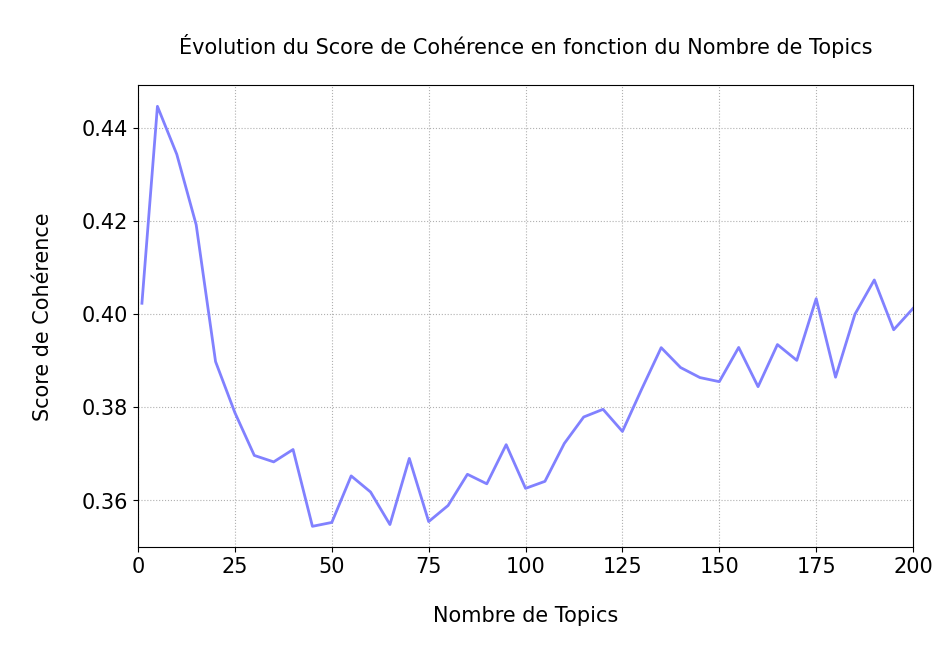

In [23]:
# Chargement des données provenant des tests réalisés (sur échantillon de 5000): 
with open('num_topics_nmf.pkl', 'rb') as fichier:
    tests_results = pickle.load(fichier)

# Réprésentation graphique des résultats : 

num_topics = list(tests_results.keys())
coherence_scores = list(tests_results.values())

# Créer un graphique à l'aide de matplotlib
plt.figure(figsize=(10, 6))  # Définir la taille du graphique (facultatif)

# Tracer la courbe des scores de cohérence
plt.plot(num_topics, coherence_scores, linestyle='-', linewidth=2, color="#8181FF")

# Ajouter des étiquettes et un titre
plt.xlabel('\nNombre de Topics\n', fontsize=15)
plt.xticks(fontsize=15)
plt.xlim(0, 200)
plt.ylabel('\nScore de Cohérence\n', fontsize=15)
plt.yticks(fontsize=15)
plt.title('\nÉvolution du Score de Cohérence en fonction du Nombre de Topics\n', fontsize=15)

# Afficher le graphique
plt.grid(True, linestyle=":")
plt.show()

<div class="alert alert-info">
Comme précécemment, nous devons considérer en priorité le contexte métier et les résultats de nos deux approches de proposition de tags qui vont suivre pour choisir le nombre de topics optimal.
</div>

- Entraînement du modèle NMF avec un nombre de topics optimal (contexte métier, résultats pour nos deux approches et scores de cohérence à titre indicatif et de comparaison) : 

In [24]:
# Ce nombre de topics permet d'apporter les meilleurs résultats à nos approches
num_topics_nmf = 150

debut = time.time()  # Heure de début du traitement

nmf_model = Nmf(corpus=corpus,
                id2word=id2word,
                num_topics=num_topics_nmf,
                random_state=100,
                chunksize=100,
                passes=5,
                kappa=1,
                minimum_probability=0.01,
                w_max_iter=300,
                w_stop_condition=0.002,
                h_max_iter=50,
                h_stop_condition=0.001,
                normalize=True
)

print(f"Durée du traitement : {(time.time() - debut):.2f} s")

Durée du traitement : 65.50 s


- Calcul du score de cohérence de ce modèle : 

In [25]:
debut = time.time()  # Heure de début du traitement

coherence_model = CoherenceModel(model=nmf_model, texts=data['corpus'], dictionary=id2word, coherence='c_v')

coherence_score = coherence_model.get_coherence()

print(f"Durée du traitement : {(time.time() - debut):.2f} s")

print(f"Score de cohérence avec {nmf_model.num_topics} topics : {coherence_score:.4f}")

Durée du traitement : 23.28 s
Score de cohérence avec 150 topics : 0.4117


- Affichage des topics trouvés avec ce modèle : 

*num_words* pour choisir le nombre de mot à afficher pour chaque topic<br>
À chaque mot est associé un nombre : son importance pour le topic en question.


In [26]:
# Nombre de mots à afficher pour chaque topics
num_words = 10

topics_nmf = nmf_model.show_topics(num_topics=nmf_model.num_topics, num_words=num_words)

for topic in topics_nmf[:10]: # 10 premiers seulement
    print(topic)

(0, '0.441*"api" + 0.038*"response" + 0.033*"endpoint" + 0.028*"core" + 0.023*"rest" + 0.020*"web" + 0.018*"gateway" + 0.015*"asp" + 0.012*"controller" + 0.011*"route"')
(1, '0.313*"sample" + 0.253*"gdal" + 0.203*"util" + 0.053*"win" + 0.020*"setup" + 0.019*"building" + 0.014*"temp" + 0.011*"extension" + 0.007*"import" + 0.007*"build"')
(2, '0.472*"number" + 0.036*"bit" + 0.028*"count" + 0.021*"integer" + 0.018*"digit" + 0.009*"range" + 0.009*"conversion" + 0.007*"sum" + 0.007*"phone" + 0.007*"float"')
(3, '0.390*"window" + 0.034*"url" + 0.028*"powershell" + 0.020*"studio" + 0.014*"machine" + 0.014*"browser" + 0.010*"console" + 0.009*"program" + 0.008*"exe" + 0.008*"behavior"')
(4, '0.708*"work" + 0.019*"thing" + 0.012*"edit" + 0.011*"idea" + 0.006*"reason" + 0.006*"working" + 0.005*"run" + 0.004*"attempt" + 0.004*"none" + 0.004*"course"')
(5, '0.334*"default" + 0.095*"constructor" + 0.026*"option" + 0.018*"initialization" + 0.015*"value" + 0.013*"operator" + 0.013*"behavior" + 0.013*"

### **Approche 1, avec les 5 premiers mots des topics**

In [27]:
approche1(nmf_model,
          premiers_mots=5,
          real_tags=data['tags']
)

Durée du traitement : 68.77 s

---------- Métriques classiques ----------
Accuracy score : 0.024
Precision score : 0.145
Recall score : 0.055
F1 score : 0.061
Hamming loss : 0.011
---------- Métriques métier ----------
Documents avec au moins un tag réel trouvé : 9.96 %
Documents avec tous les tags réels trouvés : 2.95 %
Taux de couverture moyen : 5.81 %
Documents sans prédiction de tags : 0.00 %

Pour les 10 premiers documents : 


[['firebase', 'document', 'cloud', 'export', 'firestore'],
 ['block', 'count', 'document', 'option', 'bit'],
 ['function', 'cloud', 'lambda', 'callback', 'azure'],
 ['account', 'information', 'store', 'role', 'transaction'],
 ['type', 'typescript', 'conversion', 'union', 'disadvantage'],
 ['error', 'fix', 'resolve', 'disadvantage', 'compile'],
 ['component', 'prop', 'render', 'blazor', 'vue'],
 ['form', 'control', 'validation', 'submit', 'email'],
 ['button', 'press', 'radio', 'action', 'submit'],
 ['problem', 'approach', 'solve', 'fix', 'idea']]

### **Approche 2, avec 5 mots en commun avec le document (au maximum)**

In [28]:
# S'agissant du modèle et de l'approche donnant les meilleurs résultats
# j'en profite pour récupérer les tags prédits
best_pred_tags = approche2(nmf_model,
                           taille_topic=50,
                           max_mots_communs=5,
                           real_tags=data['tags'],
                           return_tags=True  # Pour que la fonction retourne les tags prédits
)

Durée du traitement : 92.66 s

Pourcentage de listes vides : 0.02%

---------- Métriques classiques ----------
Accuracy score : 0.033
Precision score : 0.424
Recall score : 0.072
F1 score : 0.105
Hamming loss : 0.009
---------- Métriques métier ----------
Documents avec au moins un tag réel trouvé : 12.90 %
Documents avec tous les tags réels trouvés : 3.87 %
Taux de couverture moyen : 7.70 %
Documents sans prédiction de tags : 0.02 % (7 documents)

Pour les 10 premiers documents : 


[['firebase', 'authentication', 'app', 'error'],
 ['block'],
 ['type', 'typescript', 'signature', 'interface'],
 ['account', 'information', 'store'],
 ['type', 'structure'],
 ['need'],
 ['comment', 'reply', 'console', 'help', 'code'],
 ['form'],
 ['button', 'card'],
 ['system', 'memory', 'detail', 'bit', 'operating']]

### **B). Avec corpus en BoW TF-IDF**

In [29]:
# Ce nombre de topics permet d'apporter les meilleurs résultats à nos approches
num_topics_nmf_tfid = 131

debut = time.time()  # Heure de début du traitement

nmf_model_tfid = Nmf(corpus=tfid_corpus,
                     id2word=id2word,
                     num_topics=num_topics_nmf_tfid,
                     random_state=100,
                     chunksize=100,
                     passes=5,
                     kappa=1,
                     minimum_probability=0.01,
                     w_max_iter=300,
                     w_stop_condition=0.0002,
                     h_max_iter=100,
                     h_stop_condition=0.00001,
                     normalize=True
)

print(f"Durée du traitement : {(time.time() - debut):.2f} s")

Durée du traitement : 71.78 s


- Calcul du score de cohérence de ce modèle : 

In [30]:
debut = time.time()  # Heure de début du traitement

coherence_model = CoherenceModel(model=nmf_model_tfid, texts=data['corpus'], dictionary=id2word, coherence='c_v')

coherence_score = coherence_model.get_coherence()

print(f"Durée du traitement : {(time.time() - debut):.2f} s")

print(f"Score de cohérence avec {nmf_model_tfid.num_topics} topics : {coherence_score:.4f}")

Durée du traitement : 21.47 s
Score de cohérence avec 131 topics : 0.4153


- Affichage des topics trouvés avec ce modèle : 

*num_words* pour choisir le nombre de mot à afficher pour chaque topic<br>
À chaque mot est associé un nombre : son importance pour le topic en question.

In [31]:
# Nombre de mots à afficher pour chaque topics
num_words = 10

topics_nmf_tfid = nmf_model_tfid.show_topics(num_topics=nmf_model_tfid.num_topics, num_words=num_words)

for topic in topics_nmf_tfid[:10]: # 10 premiers seulement
    print(topic)

(0, '0.398*"item" + 0.017*"menu" + 0.012*"collection" + 0.010*"order" + 0.010*"grid" + 0.008*"selection" + 0.008*"height" + 0.007*"show" + 0.007*"remove" + 0.007*"scroll"')
(1, '0.270*"server" + 0.092*"bar" + 0.025*"chart" + 0.020*"blazor" + 0.018*"progress" + 0.017*"connection" + 0.016*"port" + 0.015*"graph" + 0.011*"side" + 0.010*"navigation"')
(2, '0.447*"parameter" + 0.088*"template" + 0.018*"pack" + 0.016*"param" + 0.014*"default" + 0.012*"pass" + 0.010*"powershell" + 0.008*"case" + 0.007*"signature" + 0.007*"procedure"')
(3, '0.301*"application" + 0.033*"issue" + 0.016*"store" + 0.015*"log" + 0.013*"run" + 0.012*"web" + 0.012*"configuration" + 0.010*"update" + 0.010*"console" + 0.009*"insight"')
(4, '0.273*"time" + 0.074*"display" + 0.024*"second" + 0.024*"hour" + 0.023*"minute" + 0.018*"zone" + 0.013*"device" + 0.013*"complexity" + 0.011*"timestamp" + 0.010*"interval"')
(5, '0.407*"error" + 0.038*"fix" + 0.024*"issue" + 0.012*"resolve" + 0.011*"run" + 0.011*"typeerror" + 0.011*"

### **Approche 1, avec les 5 premiers mots des topics**

In [32]:
approche1(nmf_model_tfid,
          premiers_mots=5,
          real_tags=data['tags']
)

Durée du traitement : 64.47 s

---------- Métriques classiques ----------
Accuracy score : 0.024
Precision score : 0.192
Recall score : 0.060
F1 score : 0.069
Hamming loss : 0.011
---------- Métriques métier ----------
Documents avec au moins un tag réel trouvé : 10.66 %
Documents avec tous les tags réels trouvés : 3.44 %
Taux de couverture moyen : 6.46 %
Documents sans prédiction de tags : 0.00 %

Pour les 10 premiers documents : 


[['firebase', 'cloud', 'firestore', 'emulator', 'authentication'],
 ['job', 'block', 'language', 'spark', 'cron'],
 ['type', 'typescript', 'union', 'definition', 'hint'],
 ['store', 'expo', 'account', 'information', 'typescript'],
 ['structure', 'tree', 'link', 'tag', 'level'],
 ['error', 'fix', 'issue', 'resolve', 'run'],
 ['comment', 'sum', 'issue', 'edit', 'solution'],
 ['object', 'json', 'key', 'member', 'collection'],
 ['button', 'press', 'radio', 'change', 'dialog'],
 ['problem', 'system', 'solution', 'process', 'feature']]

### **Approche 2, avec 5 mots en commun avec le document (au maximum)**

In [33]:
approche2(nmf_model_tfid,
          taille_topic=50,
          max_mots_communs=5,
          real_tags=data['tags']
)

Durée du traitement : 95.28 s

Pourcentage de listes vides : 0.01%

---------- Métriques classiques ----------
Accuracy score : 0.033
Precision score : 0.444
Recall score : 0.067
F1 score : 0.100
Hamming loss : 0.009
---------- Métriques métier ----------
Documents avec au moins un tag réel trouvé : 11.95 %
Documents avec tous les tags réels trouvés : 3.66 %
Taux de couverture moyen : 7.17 %
Documents sans prédiction de tags : 0.01 % (5 documents)

Pour les 10 premiers documents : 


[['firebase', 'authentication', 'idea'],
 ['job', 'block', 'language'],
 ['type', 'typescript', 'signature', 'way', 'case'],
 ['store', 'expo', 'account', 'information', 'play'],
 ['structure', 'part', 'example'],
 ['import', 'need', 'importing', 'nextjs', 'tsx'],
 ['comment', 'reply', 'code', 'help'],
 ['form', 'way'],
 ['button', 'card'],
 ['problem', 'system', 'process', 'feature', 'training']]

## **Meilleur modèle**

|                                |LDA                 |LDA (TF-IDF)                          |NMF                                   |NMF (TF-IDF)                           |
|---                             |---                 |---                                   |---                                   |---                                    |
|**Fit time**                    | 64.53 s            |<font color="green">**34.02 s**</font>|       65.50 s                        |     71.78 s                           |
|**n topics**                    |150                 |56                                    |150                                   |131                                    |
|**Cohérence**                   |  0.3825            | 0.3606                               |   0.4117                             |<font color="green">**0.4153**</font>  |
|**Approche 1** (au moins 1 tag) |   8.83 %           |  7.13 %                              |    9.96 %                            |<font color="green">**10.66 %**</font> |
|**Approche 1** (tous les tags)  | 2.75 %             |  1.78 %                              |    2.95 %                            |  <font color="green">**3.44 %**</font>|
|**Approche 1** (couverture moy) |  5.28 %            |  4.03 %                              |    5.81 %                            |  <font color="green">**6.46 %**</font>|
|**Approche 1** (sans prédiction)|  0.00 %            |  0.00 %                              |    0.00 %                            |   0.00 %                              |
|**Approche 2** (au moins 1 tag) |8.22 %              |  11.64 %                             |<font color="green">**12.90 %**</font>|  11.95 %                              |
|**Approche 2** (tous les tags)  |  2.28 %            |   3.36 %                             |<font color="green">**3.87 %**</font> |  3.66 %                               |
|**Approche 2** (couverture moy) |  4.77 %            |   6.87 %                             |<font color="green">**7.70 %**</font> |  7.17 %                               |
|**Approche 2** (sans prédiction)|0.00 % (1 documents)|   0.12 % (58 documents)              |    0.02 % (7 documents)              |  0.01 % (5 documents)                 |

**Les meilleurs résultats, en terme de correspondance entre les tags prédits et les tags réels, sont obtenus avec le modèle NMF utilisé avec un corpus vectorisé en BoW classique, avec la deuxième approche.**

## **Wordcloud des tags réels**

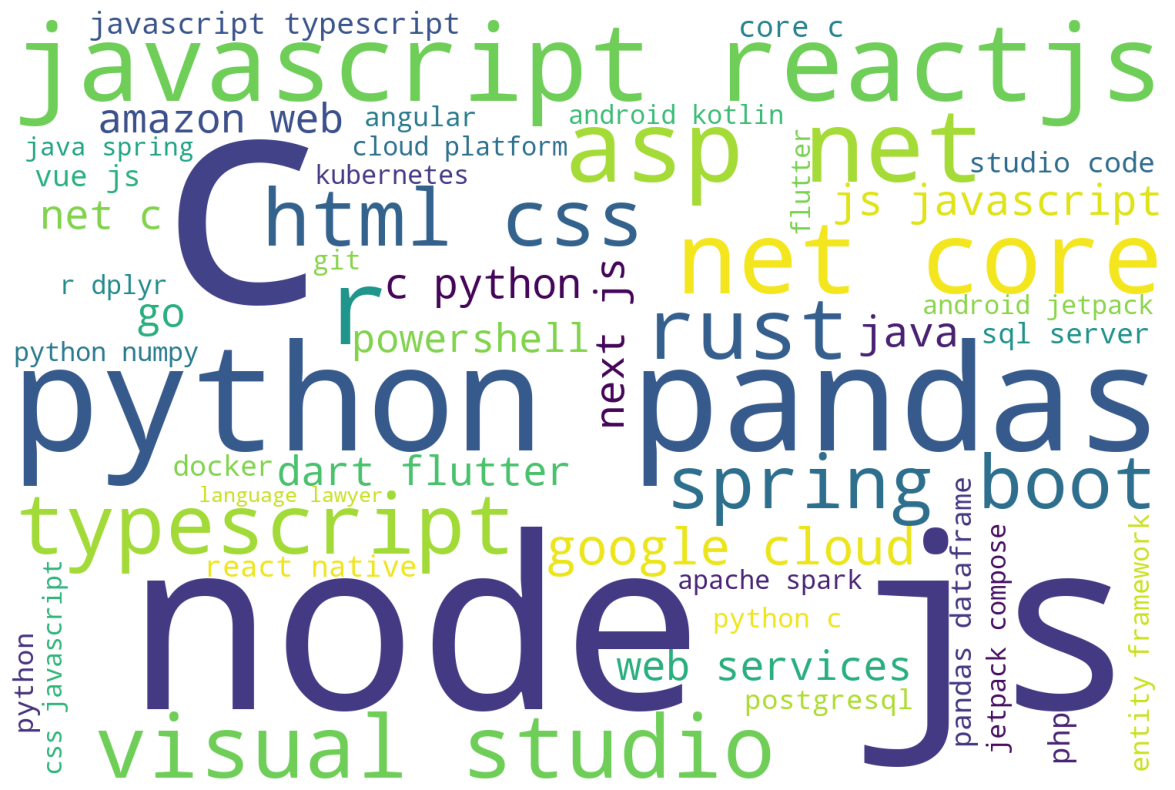

In [34]:
all_tags = data['tags'].explode()

# Words cloud
plt.figure(figsize=(15, 10))  # On dimentionne l'image à 15*10 pouces,
                              # donc avec le dpi par défaut de 100, cela donne 1500*1000px

tags_cloud = WordCloud(background_color='white',
                      stopwords=[],
                      max_words=50,
                      width=1500,  # Dimention en px de l'image à faire entrer 
                      height=1000  # dans la figure plt de 15*10 pouces
                      ).generate(" ".join(all_tags))

plt.imshow(tags_cloud)
plt.axis("off")
plt.show()

## **Wordcloud des tags prédits avec le meilleur modèle**

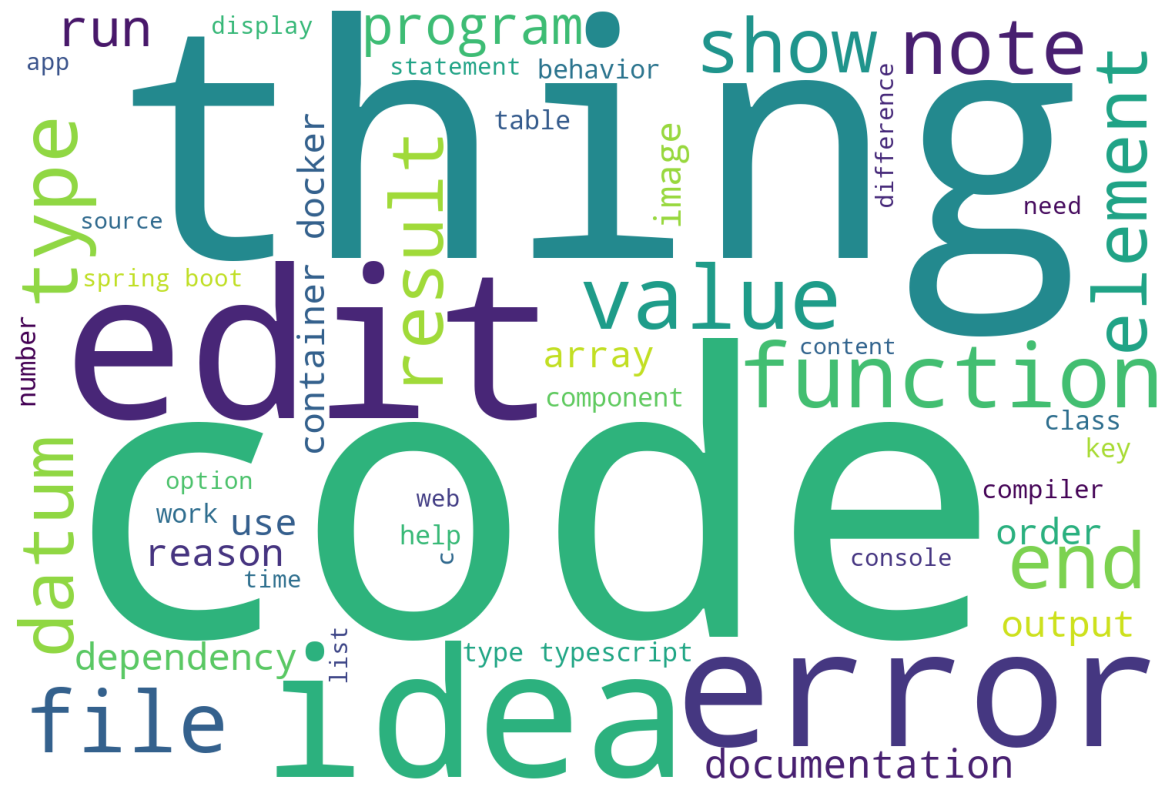

In [35]:
# On récupère 'best_pred_tags', les tags prédits avec le meilleur modèle/approche,
# qui est une liste de liste, et on mets tous les tags dans une liste simple
all_pred_tags = [element for sous_liste in best_pred_tags for element in sous_liste]

# Words cloud
plt.figure(figsize=(15, 10))  # On dimentionne l'image à 15*10 pouces,
                              # donc avec le dpi par défaut de 100, cela donne 1500*1000px

tags_cloud = WordCloud(background_color='white',
                      stopwords=[],
                      max_words=50,
                      width=1500,  # Dimention en px de l'image à faire entrer 
                      height=1000  # dans la figure plt de 15*10 pouces
                      ).generate(" ".join(all_pred_tags))

plt.imshow(tags_cloud)
plt.axis("off")
plt.show()

C'est assez différent du wordcloud des tags réels.

- On ajoute les tags prédits avec le meilleur modèle à notre dataframe : 

In [36]:
data['predicted_tags'] = best_pred_tags

- On teste sur un sample pour voir si les prédictions ont du sens : 

In [37]:
for i in data.sample(10).iterrows():
    print("Corpus :", i[1]['corpus'])
    print("Tags réels :", i[1]['tags'])
    print("Tags prédits :", i[1]['predicted_tags'])
    print("-"*50)

Corpus : ['spawn', 'process', 'package', 'use', 'case', 'running', 'lot', 'datum', 'load', 'table', 'snowflake', 'view', 'datum', 'table', 'library', 'data', 'load', 'package', 'library', 'laptop', 'code', 'code', 'snowflake', 'machine', 'snowflake', 'fork', 'spawn', 'process', 'processing', 'thought', 'datum', 'loading', 'package', 'level', 'question', 'request', 'query', 'input', 'error', 'message', 'site', 'package', 'line', 'self', 'pid', 'operation', 'function', 'handler']
Tags réels : ['snowflake-cloud-data-platform', 'python']
Tags prédits : ['package', 'site', 'self']
--------------------------------------------------
Corpus : ['reference', 'question', 'error', 'error', 'procedure', 'reference', 'error', 'oracle', 'post', 'figure', 'answer', 'code', 'table', 'type', 'want', 'test', 'procedure', 'call', 'procedure', 'input', 'value', 'course', 'parameter', 'type', 'calling', 'procedure', 'error', 'comment', 'assign', 'value', 'element', 'record', 'collection', 'overcome', 'error

- Dans quelle proportion les tags réels apparaissent dans le texte des documents ?

In [38]:
# Fonction pour vérifier si au moins un mot de la liste "tags" est présent dans le texte "corpus"
def has_tag_in_corpus(tags, corpus):
    for tag in tags:
        if tag in corpus:
            return True
    return False

# Application de la fonction et création de la colonne "tag_in_corpus_before"
presences = data.apply(lambda row: has_tag_in_corpus(row['tags'], row['corpus']), axis=1)

# Proportion de documents qui contiennent au moins un tag
proportion_before = presences.sum() / len(data)

print(f"La proportion de documents où au moins un tag réel associé est présent dans son texte est de : {proportion_before:.2%}")

La proportion de documents où au moins un tag réel associé est présent dans son texte est de : 34.92%


<div class="alert alert-info">
Puisque ces prédictions sont issues de l'approche n°2, à savoir que les tags proposés doivent se trouver dans le texte du document, ils sont rarement complètement incohérents. Cependant, ils sont rarement en adéquation avec les tags réels. Gardons en tête que les tags prédits le sont à partir des mots contenus dans les documents uniquement et que les tags réels n'apparaissent dans le contenu des documents que dans 34.92 % des cas.
</div>

- Test du meilleur modèle sur un nouveau document, avec l'approche n°2 : 

In [39]:
# Document à tester
document = [
    ['project', 'c', 'clion', 'class', 'method', 'definition', 'explanation', 'attribute', 'c', 'member', 'function', 'order', 'highlight', 'compile', 'time', 'return', 'value', 'cppreference', 'com', 'function', 'function', 'enumeration', 'class', 'value', 'value', 'expression', 'compiler', 'issue', 'warning', 'function', 'declaration', 'enumeration', 'declaration', 'class', 'declaration', 'value', 'expression', 'function', 'function', 'enumeration', 'class', 'value', 'constructor', 'type', 'conversion', 'object', 'enumeration', 'class', 'type', 'type', 'conversion', 'compiler', 'issue', 'annotation', 'location', 'return', 'value', 'caller', 'explanation']
]

# Encodage du document en utilisant le doctionnaire 'id2word'
# Si un mot n'existe pas dans le dictionnaire, il sera supprimé
doc = [id2word.doc2bow(text) for text in document]

# Obtenir les probabilités d'appartenance aux topics pour ce document
doc_topics = nmf_model.get_document_topics(doc)

# Trouver le sujet le plus probable pour ce document
most_probable_topic = max(doc_topics[0], key=lambda x: x[1])[0]

# Obtenir les mots du sujet le plus probable
top_words = [word for word, _ in nmf_model.show_topic(most_probable_topic, topn=50)]

# Conserver, parmi les 50 premiers mots du sujet, ceux qui sont également présents dans le document
words_in_document = [word for word in top_words if word in document[0]]

# On limite à 5 tags prédits
predicted_tags_new_doc = words_in_document[:5]

print("Document :", document[0])
print("Les tags prédits sont :", predicted_tags_new_doc)

Document : ['project', 'c', 'clion', 'class', 'method', 'definition', 'explanation', 'attribute', 'c', 'member', 'function', 'order', 'highlight', 'compile', 'time', 'return', 'value', 'cppreference', 'com', 'function', 'function', 'enumeration', 'class', 'value', 'value', 'expression', 'compiler', 'issue', 'warning', 'function', 'declaration', 'enumeration', 'declaration', 'class', 'declaration', 'value', 'expression', 'function', 'function', 'enumeration', 'class', 'value', 'constructor', 'type', 'conversion', 'object', 'enumeration', 'class', 'type', 'type', 'conversion', 'compiler', 'issue', 'annotation', 'location', 'return', 'value', 'caller', 'explanation']
Les tags prédits sont : ['class', 'constructor', 'definition', 'attribute', 'declaration']


- Sauvegarde du meilleur modèle entraîné et du dicionnaire.

In [40]:
best_model_non_sup_et_dico = [nmf_model, id2word]

nom_fichier = 'best_model_non_sup_et_dico'

# Enregistrement du meilleur modèle et du dictionnaire
if os.path.isfile(f'{nom_fichier}.pkl') == False:
    with open(f'{nom_fichier}.pkl', 'wb') as fichier:
        pickle.dump(best_model_non_sup_et_dico, fichier)
    print(f"Fichier {nom_fichier}.pkl créé.")
else:
    print(f"Le fichier {nom_fichier}.pkl existe déjà, si vous souhaitez en exporter une nouvelle version, supprimez l'ancien.")

Le fichier best_model_non_sup_et_dico.pkl existe déjà, si vous souhaitez en exporter une nouvelle version, supprimez l'ancien.


## **Conclusion**

- Avec l'approche non supervisée, nous avons pu prédire des tags dans des temps acceptables et ce sans réduire la taille du vocabulaire issue du préprocessing, c'est-à-dire 3707 mots.
- Même si les scores de cohérences ont été calculés, ils avaient surtout une valeur indicative, notamment pour nous permettre de comparer les différents modèles et approches.
- Le contexte métier a été considéré en priorité, notamment en se basant sur les proportions de cas où au moins un des tags réels a pu être prédit.
- La plus haute proportion de tags correctement prédits (au moins un tag réel prédit) obtenue est de 12.90 %, en gardant en tête que le maximum possible était de 34.92 % (cas où les tags réels sont présents dans le texte du document), puisque ces approches non supervisées sont uniquement basées sur le texte des documents.
- Il serait intéressant de tester des approches supervisées et de voir s'il est possible d'obtenir de meilleurs résultats (nous ne serions théoriquement plus limités à un maximum de 34.92 %).


- Mesure de la durée d'exécution du notebook : 

In [41]:
temps_secondes = time.time() - t_notebook

# Conversion en minutes et secondes
minutes = int(temps_secondes // 60)
seconds = int(temps_secondes % 60)

# Formatage du résultat
formatted_time = f"{minutes:02}:{seconds:02}"

print(f"Durée d'exécution du notebook (hors imports) : {formatted_time}")

Durée d'exécution du notebook (hors imports) : 16:40
